<a href="https://colab.research.google.com/github/HaqTetsuya/ChatbotPerpusBipa/blob/main/IndobertPerpusChatbot_lite_cleaned_refractored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download dependancy
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm deep-translator fuzzywuzzy Levenshtein

In [4]:
# @title import dependency, load drive, and github {"form-width":"20%"}
import json
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Transformers imports
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_scheduler
)

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

from tqdm.auto import tqdm

!git clone https://github.com/HaqTetsuya/ChatbotPerpusBipa.git
# Mount Google Drive
drive.mount('/content/drive')
FName = "models" #@param {type:"string"}

# Update MODEL_SAVE_PATH with user input
MODEL_SAVE_PATH = f"/content/drive/MyDrive/{FName}"

fatal: destination path 'ChatbotPerpusBipa' already exists and is not an empty directory.
Mounted at /content/drive


In [5]:
# @title ---------- Dataset Class ----------#
class IntentDataset(Dataset):
    """Dataset for intent classification with IndoBERT"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert dict of tensors to flat tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        return item

In [7]:
# @title ---------- Loss Function ----------#
class FocalLoss(nn.Module):
    """Focal Loss implementation for handling class imbalance"""

    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [8]:
# @title ---------- Data Loading Functions ----------#
def load_csv_data(csv_path, label_encoder=None, show_distribution=False):
    """Load intent data from CSV file"""
    print(f"\nLoading data from: {csv_path}")

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File not found: {csv_path}")

    df = pd.read_csv(csv_path)

    if 'text' not in df.columns or 'intent' not in df.columns:
        raise ValueError("Columns 'text' and 'intent' must exist in CSV")

    # Create or use existing label encoder
    if label_encoder is None:
        label_encoder = LabelEncoder()
        df['intent_encoded'] = label_encoder.fit_transform(df['intent'])
        print(f"New label encoder created from {csv_path}")
    else:
        df['intent_encoded'] = label_encoder.transform(df['intent'])
        print(f"Using existing label encoder")

    intent_classes = label_encoder.classes_

    # Show distribution if requested
    if show_distribution:
        intent_counts = df['intent'].value_counts()
        print("\nIntent distribution:")
        for intent, count in intent_counts.items():
            print(f"  {intent}: {count}")

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")
        plt.xlabel("Intent")
        plt.ylabel("Count")
        plt.title("Intent Distribution")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.pie(intent_counts, labels=intent_counts.index, autopct='%1.1f%%',
                colors=sns.color_palette("viridis", len(intent_counts)))
        plt.title("Intent Proportions")
        plt.tight_layout()
        plt.show()

    return df['text'].values, df['intent_encoded'].values, intent_classes, label_encoder

def prepare_data(split_dataset, val_split, train_csv_path="train.csv", val_csv_path="val.csv"):
    """Prepare training and validation data based on split mode"""
    if split_dataset.lower() == "yes":
        all_texts, all_labels, intent_classes, label_encoder = load_csv_data(
            train_csv_path, show_distribution=True)

        train_texts, val_texts, train_labels, val_labels = train_test_split(
            all_texts, all_labels, test_size=val_split, random_state=42, stratify=all_labels
        )

        print(f"\n✅ Dataset split: {len(train_texts)} training and {len(val_texts)} validation samples")
    else:
        train_texts, train_labels, intent_classes, label_encoder = load_csv_data(
            train_csv_path, show_distribution=True)
        val_texts, val_labels, _, _ = load_csv_data(
            val_csv_path, label_encoder=label_encoder, show_distribution=True)

    return train_texts, train_labels, val_texts, val_labels, intent_classes, label_encoder

In [9]:
# @title ---------- Model Setup ----------#
def setup_indobert_for_intent(num_labels):
    """Load IndoBERT model for intent classification"""
    print("Loading IndoBERT model...")
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
    model = AutoModelForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p2",
        num_labels=num_labels
    )
    print("Model loaded successfully")
    return model, tokenizer


In [10]:
# @title ---------- Training Functions ----------#
def train_intent_classifier(model, tokenizer, train_texts, train_labels, val_texts, val_labels,
                          batch_size=16, epochs=10, learning_rate=2e-5, weight_decay=0.01,
                          save_path=MODEL_SAVE_PATH, use_class_weights=True, patience=3, class_names=None):
    """Train intent classifier with early stopping and validation"""
    # Create dataset and dataloaders
    train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Setup device, optimizer, scheduler, and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Compute class weights if needed
    class_weights = None
    if use_class_weights:
        unique_classes = np.unique(train_labels)
        weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=train_labels
        )
        class_weights = torch.FloatTensor(weights).to(device)
        print(f"Using class weights: {weights}")

    # Create optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Create scheduler with warmup
    num_training_steps = len(train_dataloader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
    scheduler = get_scheduler("cosine", optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_training_steps)

    # Create loss function
    loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)
    print("Using Focal Loss with gamma=2.0")

    # Move model to device
    model.to(device)

    # Initialize training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': [],
        'batch_metrics': {
            'iteration': [],
            'loss': [],
            'epoch': [],
            'progress': [],
            'learning_rates': []
        },
        'class_f1': [],
        'class_precision': [],
        'class_recall': []
    }

    # Training loop
    best_val_loss = float('inf')
    counter = 0  # Counter for early stopping

    print(f"Starting training: {epochs} epochs, batch size: {batch_size}, LR: {learning_rate}")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                          desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for batch_idx, batch in progress_bar:
            try:
                # Move batch to device
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                # Forward and backward pass
                optimizer.zero_grad()
                outputs = model(**inputs)
                loss = loss_fn(outputs.logits, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

                # Update metrics
                train_loss += loss.item()

                # Track batch metrics
                global_iteration = epoch * len(train_dataloader) + batch_idx
                progress = (epoch + (batch_idx / len(train_dataloader))) * 100

                history['batch_metrics']['iteration'].append(global_iteration)
                history['batch_metrics']['loss'].append(loss.item())
                history['batch_metrics']['epoch'].append(epoch)
                history['batch_metrics']['progress'].append(progress)
                history['batch_metrics']['learning_rates'].append(optimizer.param_groups[0]['lr'])

                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("Warning: Out of memory! Clearing cache...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        val_metrics = validate_model(model, device, val_dataloader, loss_fn, epoch, epochs)

        # Update history with validation metrics
        history['val_loss'].append(val_metrics['avg_val_loss'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])

        # Update per-class metrics if class names are provided
        if class_names is not None:
            class_f1 = f1_score(val_metrics['all_labels'], val_metrics['all_preds'],
                               average=None, zero_division=0)
            class_precision = precision_score(val_metrics['all_labels'], val_metrics['all_preds'],
                                           average=None, zero_division=0)
            class_recall = recall_score(val_metrics['all_labels'], val_metrics['all_preds'],
                                     average=None, zero_division=0)

            history['class_f1'].append(class_f1.tolist())
            history['class_precision'].append(class_precision.tolist())
            history['class_recall'].append(class_recall.tolist())

            # Generate confusion matrix for this epoch
            plot_confusion_matrix(val_metrics['all_labels'], val_metrics['all_preds'],
                                class_names, epoch, save_path)

        # Print metrics
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {val_metrics['avg_val_loss']:.4f}, Val Accuracy: {val_metrics['accuracy']*100:.2f}%")
        print(f"  Val F1: {val_metrics['f1']:.4f}, Val Precision: {val_metrics['precision']:.4f}, Val Recall: {val_metrics['recall']:.4f}")

        if 'all_labels' in val_metrics and 'all_preds' in val_metrics:
            print(f"\nClass-wise precision/recall/F1 after epoch {epoch+1}:")
            print(classification_report(val_metrics['all_labels'], val_metrics['all_preds'], digits=4))

        # Early stopping check
        if val_metrics['avg_val_loss'] < best_val_loss:
            best_val_loss = val_metrics['avg_val_loss']
            counter = 0  # Reset counter

            # Save best model
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            print(f"Saving best model to {save_path}")
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)

            # Save classification report
            report = classification_report(val_metrics['all_labels'], val_metrics['all_preds'], output_dict=True)
            with open(os.path.join(save_path, "classification_report.json"), 'w') as f:
                json.dump(report, f, indent=4)
        else:
            counter += 1
            print(f"Validation loss not improving. Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    print(f"Training complete! Best model saved at {save_path}")

    # Generate visualizations
    create_training_visualizations(history, save_path, class_names)
    static_plot_training_results(history, save_path)
    # Save history
    save_training_history(history, save_path)

    return model, history

def validate_model(model, device, dataloader, loss_fn, epoch, epochs):
    """Validate model on validation dataset"""
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Collect predictions and labels for metrics
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Calculate metrics
    avg_val_loss = val_loss / len(dataloader)
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return {
        'avg_val_loss': avg_val_loss,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'all_preds': all_preds,
        'all_labels': all_labels
    }

In [11]:
# @title ---------- Visualization Functions ----------#
def create_training_visualizations(history, save_path, class_names=None):
    """Create visualizations for training history"""
    # Create directories
    os.makedirs(os.path.join(save_path, "class_metrics"), exist_ok=True)

    # Plot learning rate if available
    if 'batch_metrics' in history and 'learning_rates' in history['batch_metrics']:
        plt.figure(figsize=(12, 6))
        plt.plot(history['batch_metrics']['iteration'], history['batch_metrics']['learning_rates'])
        plt.title('Learning Rate Schedule')
        plt.xlabel('Iteration')
        plt.ylabel('Learning Rate')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "learning_rate_schedule.png"))
        plt.close()

    # Plot per-class F1 scores if available
    if 'class_f1' in history and class_names is not None:
        plt.figure(figsize=(12, 8))

        epochs = len(history['class_f1'])
        x_epochs = list(range(1, epochs + 1))

        for i, class_name in enumerate(class_names):
            class_f1 = [history['class_f1'][epoch][i] for epoch in range(epochs)]
            plt.plot(x_epochs, class_f1, marker='o', label=f'{class_name}')

        plt.title('F1 Score per Class')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "class_metrics", "f1_per_class.png"))
        plt.close()

def static_plot_training_results(history, save_path):
    """Plot and save training metrics using matplotlib (static)"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
    plt.title('Akurasi selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['val_f1'], label='Validation F1', marker='o', color='purple')
    plt.title('F1 Score selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: Precision & Recall
    plt.subplot(2, 2, 4)
    plt.plot(history['val_precision'], label='Validation Precision', marker='o', color='orange')
    plt.plot(history['val_recall'], label='Validation Recall', marker='o', color='brown')
    plt.title('Precision & Recall selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(save_path, "training_metrics.png"))
    plt.close()

def plot_confusion_matrix(all_labels, all_preds, class_names, epoch, save_path):
    """Plot and save confusion matrix for an epoch"""
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Save the confusion matrix
    cm_dir = os.path.join(save_path, "confusion_matrices")
    os.makedirs(cm_dir, exist_ok=True)
    plt.savefig(os.path.join(cm_dir, f"cm_epoch_{epoch+1}.png"))
    plt.close()

def save_training_history(history, save_path):
    """Save training history to JSON file"""
    # Convert numpy arrays to lists for JSON serialization
    processed_history = {}

    for key, value in history.items():
        if isinstance(value, dict):
            processed_history[key] = {}
            for subkey, subvalue in value.items():
                processed_history[key][subkey] = convert_to_serializable(subvalue)
        else:
            processed_history[key] = convert_to_serializable(value)

    # Save history
    with open(os.path.join(save_path, "training_history.json"), 'w') as f:
        json.dump(processed_history, f, indent=4)

    print(f"Training history saved to {os.path.join(save_path, 'training_history.json')}")

def convert_to_serializable(value):
    """Convert numpy arrays and other non-serializable types to JSON-compatible types"""
    if isinstance(value, np.ndarray):
        return value.tolist()
    elif isinstance(value, list):
        if value and isinstance(value[0], np.ndarray):
            return [item.tolist() if isinstance(item, np.ndarray) else item for item in value]
        else:
            return value
    else:
        return value


In [12]:
# @title ---------- Evaluation Functions ----------#
def evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes, save_path):
    """Evaluate model and generate reports"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Prepare dataset and dataloader
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    all_preds = []
    all_labels = []

    # Evaluation loop
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating Model"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Generate classification report
    report = classification_report(all_labels, all_preds,
                                 target_names=intent_classes,
                                 output_dict=True)

    # Create dataframe for visualization
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(3)

    # Save classification metrics as CSV
    report_df.to_csv(os.path.join(save_path, "classification_report.csv"))

    # Create confusion matrix visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=intent_classes, yticklabels=intent_classes)
    plt.title('Confusion Matrix - Final Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "final_confusion_matrix.png"))
    plt.close()

    # Create classification report heatmap
    class_df = report_df.loc[intent_classes]
    metrics = ['precision', 'recall', 'f1-score']

    plt.figure(figsize=(12, len(intent_classes)*0.5 + 3))
    sns.heatmap(class_df[metrics], annot=True, cmap='YlGnBu', fmt='.3f',
               yticklabels=intent_classes, cbar=True)
    plt.title('Performance Metrics by Intent Class')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "class_performance_metrics.png"))
    plt.close()

    # Print report summary
    print("\nModel Evaluation Report:")
    print(f"Overall Accuracy: {report['accuracy']:.4f}")
    print(f"Macro F1-score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted F1-score: {report['weighted avg']['f1-score']:.4f}")

    return report, cm

In [13]:
# @title ---------- OOD Detection ----------#
def calibrate_ood_detection(model, tokenizer, dataloader, temperature=1.0, percentile=70, margin=0.1):
    """Calibrate thresholds for out-of-distribution detection"""
    device = next(model.parameters()).device
    model.eval()

    # For Energy method and MSP method
    energy_scores = []
    msp_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calibrating OOD detection"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits

            # Energy score (higher values for OOD)
            energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
            energy_scores.extend(energy.cpu().numpy())

            # MSP score (lower values for OOD)
            softmax_probs = F.softmax(logits, dim=1)
            max_probs, _ = torch.max(softmax_probs, dim=1)
            msp_scores.extend(max_probs.cpu().numpy())

    # Calculate thresholds with margin
    base_energy_threshold = np.percentile(energy_scores, percentile)
    energy_threshold = base_energy_threshold * (1 + margin)

    base_msp_threshold = np.percentile(msp_scores, 100 - percentile)
    msp_threshold = base_msp_threshold * (1 - margin)

    return {
        "energy_threshold": float(energy_threshold),
        "msp_threshold": float(msp_threshold)
    }

def save_ood_thresholds(thresholds, save_path):
    """Save OOD detection thresholds to file"""
    threshold_file = os.path.join(save_path, "ood_thresholds.json")
    with open(threshold_file, 'w') as f:
        json.dump(thresholds, f, indent=4)
    print(f"OOD thresholds saved at {threshold_file}")
    return threshold_file

def load_ood_thresholds(model_path):
    """Load OOD detection thresholds from file"""
    try:
        with open(os.path.join(model_path, "ood_thresholds.json"), 'r') as f:
            thresholds = json.load(f)
            return thresholds
    except FileNotFoundError:
        try:
            with open(os.path.join(model_path, "ood_threshold.json"), 'r') as f:
                threshold_data = json.load(f)
                return {
                    "energy_threshold": threshold_data["energy_threshold"],
                    "msp_threshold": None
                }
        except FileNotFoundError:
            print("Warning: OOD threshold files not found. Using default thresholds.")
            return {
                "energy_threshold": 0.0,
                "msp_threshold": 0.5
            }

In [14]:
# @title ---------- Main Pipeline ----------#
def run_intent_classification_pipeline(
    use_drive=True,
    percentile=95,
    split_dataset="no",
    val_split=0.2,
    batch_size=16,
    epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    patience=3,
    train_csv_path="train.csv",
    val_csv_path="val.csv"
):
    """Run full intent classification pipeline"""
    # Create save directory
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

    # Prepare data
    train_texts, train_labels, val_texts, val_labels, intent_classes, label_encoder = prepare_data(
        split_dataset, val_split, train_csv_path, val_csv_path)

    num_labels = len(intent_classes)
    print(f"Number of intents: {num_labels}")
    print(f"Supported intents: {', '.join(intent_classes)}")

    # Setup model
    model, tokenizer = setup_indobert_for_intent(num_labels)

    # Train model
    model, history = train_intent_classifier(
        model,
        tokenizer,
        train_texts,
        train_labels,
        val_texts,
        val_labels,
        class_names=intent_classes,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        patience=patience
    )

    # Prepare validation dataloader for OOD calibration
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    # Calibrate OOD detection
    thresholds = calibrate_ood_detection(model, tokenizer, val_dataloader, percentile=percentile)
    save_ood_thresholds(thresholds, MODEL_SAVE_PATH)
    print(f"OOD detection thresholds: Energy={thresholds['energy_threshold']:.4f}, MSP={thresholds['msp_threshold']:.4f}")

    # Evaluate model
    report, cm = evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes, MODEL_SAVE_PATH)

    # Save intent classes & label encoder
    with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "wb") as f:
        pickle.dump(intent_classes, f)

    with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    print(f"\n✅ Model successfully trained and saved at {MODEL_SAVE_PATH}")
    print(f"Visualizations saved at {MODEL_SAVE_PATH}")

    return model, tokenizer, intent_classes, label_encoder


Loading data from: train.csv
New label encoder created from train.csv

Intent distribution:
  keanggotaan: 879
  fasilitas: 874
  cari_buku: 862
  jam_layanan: 846
  goodbye: 722
  denied: 665
  confirm: 558
  greeting: 551


<ipython-input-8-7e418f7d4776>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")


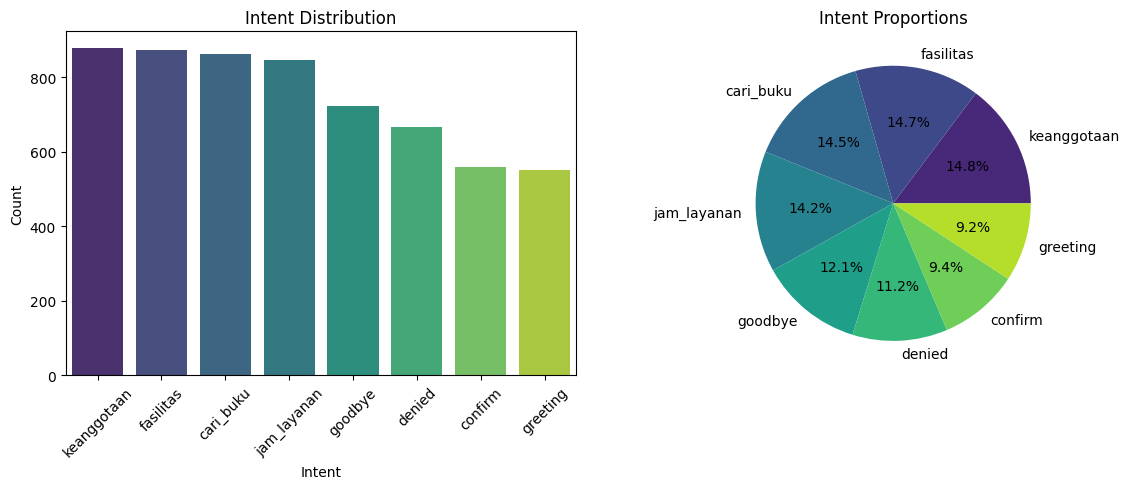


✅ Dataset split: 4765 training and 1192 validation samples
Number of intents: 8
Supported intents: cari_buku, confirm, denied, fasilitas, goodbye, greeting, jam_layanan, keanggotaan
Loading IndoBERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully
Using device: cuda
Using class weights: [0.8644775  1.33548206 1.11959586 0.85211016 1.03049308 1.35062358
 0.87980059 0.84726174]
Using Focal Loss with gamma=2.0
Starting training: 12 epochs, batch size: 32, LR: 2.5e-05


Epoch 1/12 [Training]:   0%|          | 0/149 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1/12 [Validation]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 1/12:
  Train Loss: 0.6485
  Val Loss: 0.0557, Val Accuracy: 96.64%
  Val F1: 0.9673, Val Precision: 0.9726, Val Recall: 0.9664

Class-wise precision/recall/F1 after epoch 1:
              precision    recall  f1-score   support

           0     0.9943    1.0000    0.9971       173
           1     0.7778    1.0000    0.8750       112
           2     1.0000    0.8496    0.9187       133
           3     1.0000    0.9657    0.9826       175
           4     1.0000    0.9583    0.9787       144
           5     1.0000    0.9364    0.9671       110
           6     1.0000    0.9941    0.9970       169
           7     0.9617    1.0000    0.9805       176

    accuracy                         0.9664      1192
   macro avg     0.9667    0.9630    0.9621      1192
weighted avg     0.9726    0.9664    0.9673      1192

Saving best model to /content/drive/MyDrive/models


Epoch 2/12 [Training]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 2/12 [Validation]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2/12:
  Train Loss: 0.0350
  Val Loss: 0.0238, Val Accuracy: 98.99%
  Val F1: 0.9900, Val Precision: 0.9901, Val Recall: 0.9899

Class-wise precision/recall/F1 after epoch 2:
              precision    recall  f1-score   support

           0     0.9943    1.0000    0.9971       173
           1     0.9909    0.9732    0.9820       112
           2     0.9924    0.9850    0.9887       133
           3     1.0000    0.9829    0.9914       175
           4     0.9930    0.9792    0.9860       144
           5     0.9478    0.9909    0.9689       110
           6     1.0000    1.0000    1.0000       169
           7     0.9888    1.0000    0.9944       176

    accuracy                         0.9899      1192
   macro avg     0.9884    0.9889    0.9885      1192
weighted avg     0.9901    0.9899    0.9900      1192

Saving best model to /content/drive/MyDrive/models


Epoch 3/12 [Training]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 3/12 [Validation]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3/12:
  Train Loss: 0.0104
  Val Loss: 0.0170, Val Accuracy: 99.08%
  Val F1: 0.9908, Val Precision: 0.9908, Val Recall: 0.9908

Class-wise precision/recall/F1 after epoch 3:
              precision    recall  f1-score   support

           0     0.9943    1.0000    0.9971       173
           1     1.0000    0.9911    0.9955       112
           2     0.9924    0.9850    0.9887       133
           3     0.9942    0.9829    0.9885       175
           4     0.9862    0.9931    0.9896       144
           5     0.9643    0.9818    0.9730       110
           6     0.9882    0.9941    0.9912       169
           7     1.0000    0.9943    0.9972       176

    accuracy                         0.9908      1192
   macro avg     0.9900    0.9903    0.9901      1192
weighted avg     0.9908    0.9908    0.9908      1192

Saving best model to /content/drive/MyDrive/models


Epoch 4/12 [Training]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 4/12 [Validation]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4/12:
  Train Loss: 0.0030
  Val Loss: 0.0175, Val Accuracy: 99.41%
  Val F1: 0.9941, Val Precision: 0.9942, Val Recall: 0.9941

Class-wise precision/recall/F1 after epoch 4:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       173
           1     1.0000    0.9911    0.9955       112
           2     0.9924    0.9850    0.9887       133
           3     0.9943    0.9943    0.9943       175
           4     0.9862    0.9931    0.9896       144
           5     0.9732    0.9909    0.9820       110
           6     1.0000    0.9941    0.9970       169
           7     1.0000    1.0000    1.0000       176

    accuracy                         0.9941      1192
   macro avg     0.9933    0.9935    0.9934      1192
weighted avg     0.9942    0.9941    0.9941      1192

Validation loss not improving. Early stopping counter: 1/3


Epoch 5/12 [Training]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 5/12 [Validation]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5/12:
  Train Loss: 0.0014
  Val Loss: 0.0175, Val Accuracy: 99.24%
  Val F1: 0.9924, Val Precision: 0.9925, Val Recall: 0.9924

Class-wise precision/recall/F1 after epoch 5:
              precision    recall  f1-score   support

           0     0.9943    1.0000    0.9971       173
           1     0.9911    0.9911    0.9911       112
           2     0.9925    0.9925    0.9925       133
           3     0.9943    0.9943    0.9943       175
           4     0.9795    0.9931    0.9862       144
           5     0.9907    0.9636    0.9770       110
           6     0.9941    0.9941    0.9941       169
           7     1.0000    1.0000    1.0000       176

    accuracy                         0.9924      1192
   macro avg     0.9920    0.9911    0.9915      1192
weighted avg     0.9925    0.9924    0.9924      1192

Validation loss not improving. Early stopping counter: 2/3


Epoch 6/12 [Training]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 6/12 [Validation]:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6/12:
  Train Loss: 0.0011
  Val Loss: 0.0183, Val Accuracy: 99.24%
  Val F1: 0.9925, Val Precision: 0.9926, Val Recall: 0.9924

Class-wise precision/recall/F1 after epoch 6:
              precision    recall  f1-score   support

           0     0.9943    1.0000    0.9971       173
           1     0.9573    1.0000    0.9782       112
           2     1.0000    0.9774    0.9886       133
           3     0.9943    1.0000    0.9972       175
           4     0.9930    0.9861    0.9895       144
           5     0.9907    0.9727    0.9817       110
           6     1.0000    0.9941    0.9970       169
           7     1.0000    1.0000    1.0000       176

    accuracy                         0.9924      1192
   macro avg     0.9912    0.9913    0.9912      1192
weighted avg     0.9926    0.9924    0.9925      1192

Validation loss not improving. Early stopping counter: 3/3
Early stopping triggered after 6 epochs
Training complete! Best model saved at /content/drive/MyDrive/models


Calibrating OOD detection:   0%|          | 0/75 [00:00<?, ?it/s]

OOD thresholds saved at /content/drive/MyDrive/models/ood_thresholds.json
OOD detection thresholds: Energy=-5.3182, MSP=0.8681


Evaluating Model:   0%|          | 0/75 [00:00<?, ?it/s]


Model Evaluation Report:
Overall Accuracy: 0.9924
Macro F1-score: 0.9912
Weighted F1-score: 0.9925

✅ Model successfully trained and saved at /content/drive/MyDrive/models
Visualizations saved at /content/drive/MyDrive/models


In [15]:
# Run the pipeline
if __name__ == "__main__":
    model, tokenizer, intent_classes, label_encoder = run_intent_classification_pipeline(
        use_drive=True,
        percentile=90,
        split_dataset="yes",
        val_split=0.20,
        batch_size=32,
        epochs=12,
        learning_rate=2.5e-5,
        weight_decay=0.01,
        patience=3,
        train_csv_path="train.csv",
		val_csv_path="val.csv"
		)